In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import h5py
import shutil
from tqdm import tqdm

import numpy as np

from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp

import powerbox as pbox

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

## 0. Get lightcones

In [2]:
ddir = '/n/holyscratch01/iaifi_lab/yitians/dm21cm/outputs/fc_xdecay'

In [3]:
! ls /n/holyscratch01/iaifi_lab/yitians/dm21cm/outputs/fc_xdecay

lc_fc_xdecay_zf001_sf20_noxesink.h5  lc_fc_xdecay_zf005_sf4_noxesink.h5
lc_fc_xdecay_zf001_sf20_xesink.h5    lc_fc_xdecay_zf005_sf4_xesink.h5
lc_fc_xdecay_zf002_sf10_noxesink.h5  lc_fc_xdecay_zf01_sf2_noxesink.h5
lc_fc_xdecay_zf002_sf10_xesink.h5    lc_fc_xdecay_zf01_sf2_xesink.h5


In [4]:
zf_s = ['001', '002', '005', '01']
sf_s = [20, 10, 4, 2]
keys = ['T_k', 'x_e', 'T_b']

In [5]:
# load fields
box_s = {k : [] for k in keys}

for i in range(len(zf_s)):
    with h5py.File(f"{ddir}/lc_fc_xdecay_zf{zf_s[i]}_sf{sf_s[i]}_xesink.h5", 'r') as hf:
        box_s['T_k'].append(hf['lightcones']['Tk_box'][()])
        box_s['x_e'].append(hf['lightcones']['x_e_box'][()])
        box_s['T_b'].append(hf['lightcones']['brightness_temp'][()])

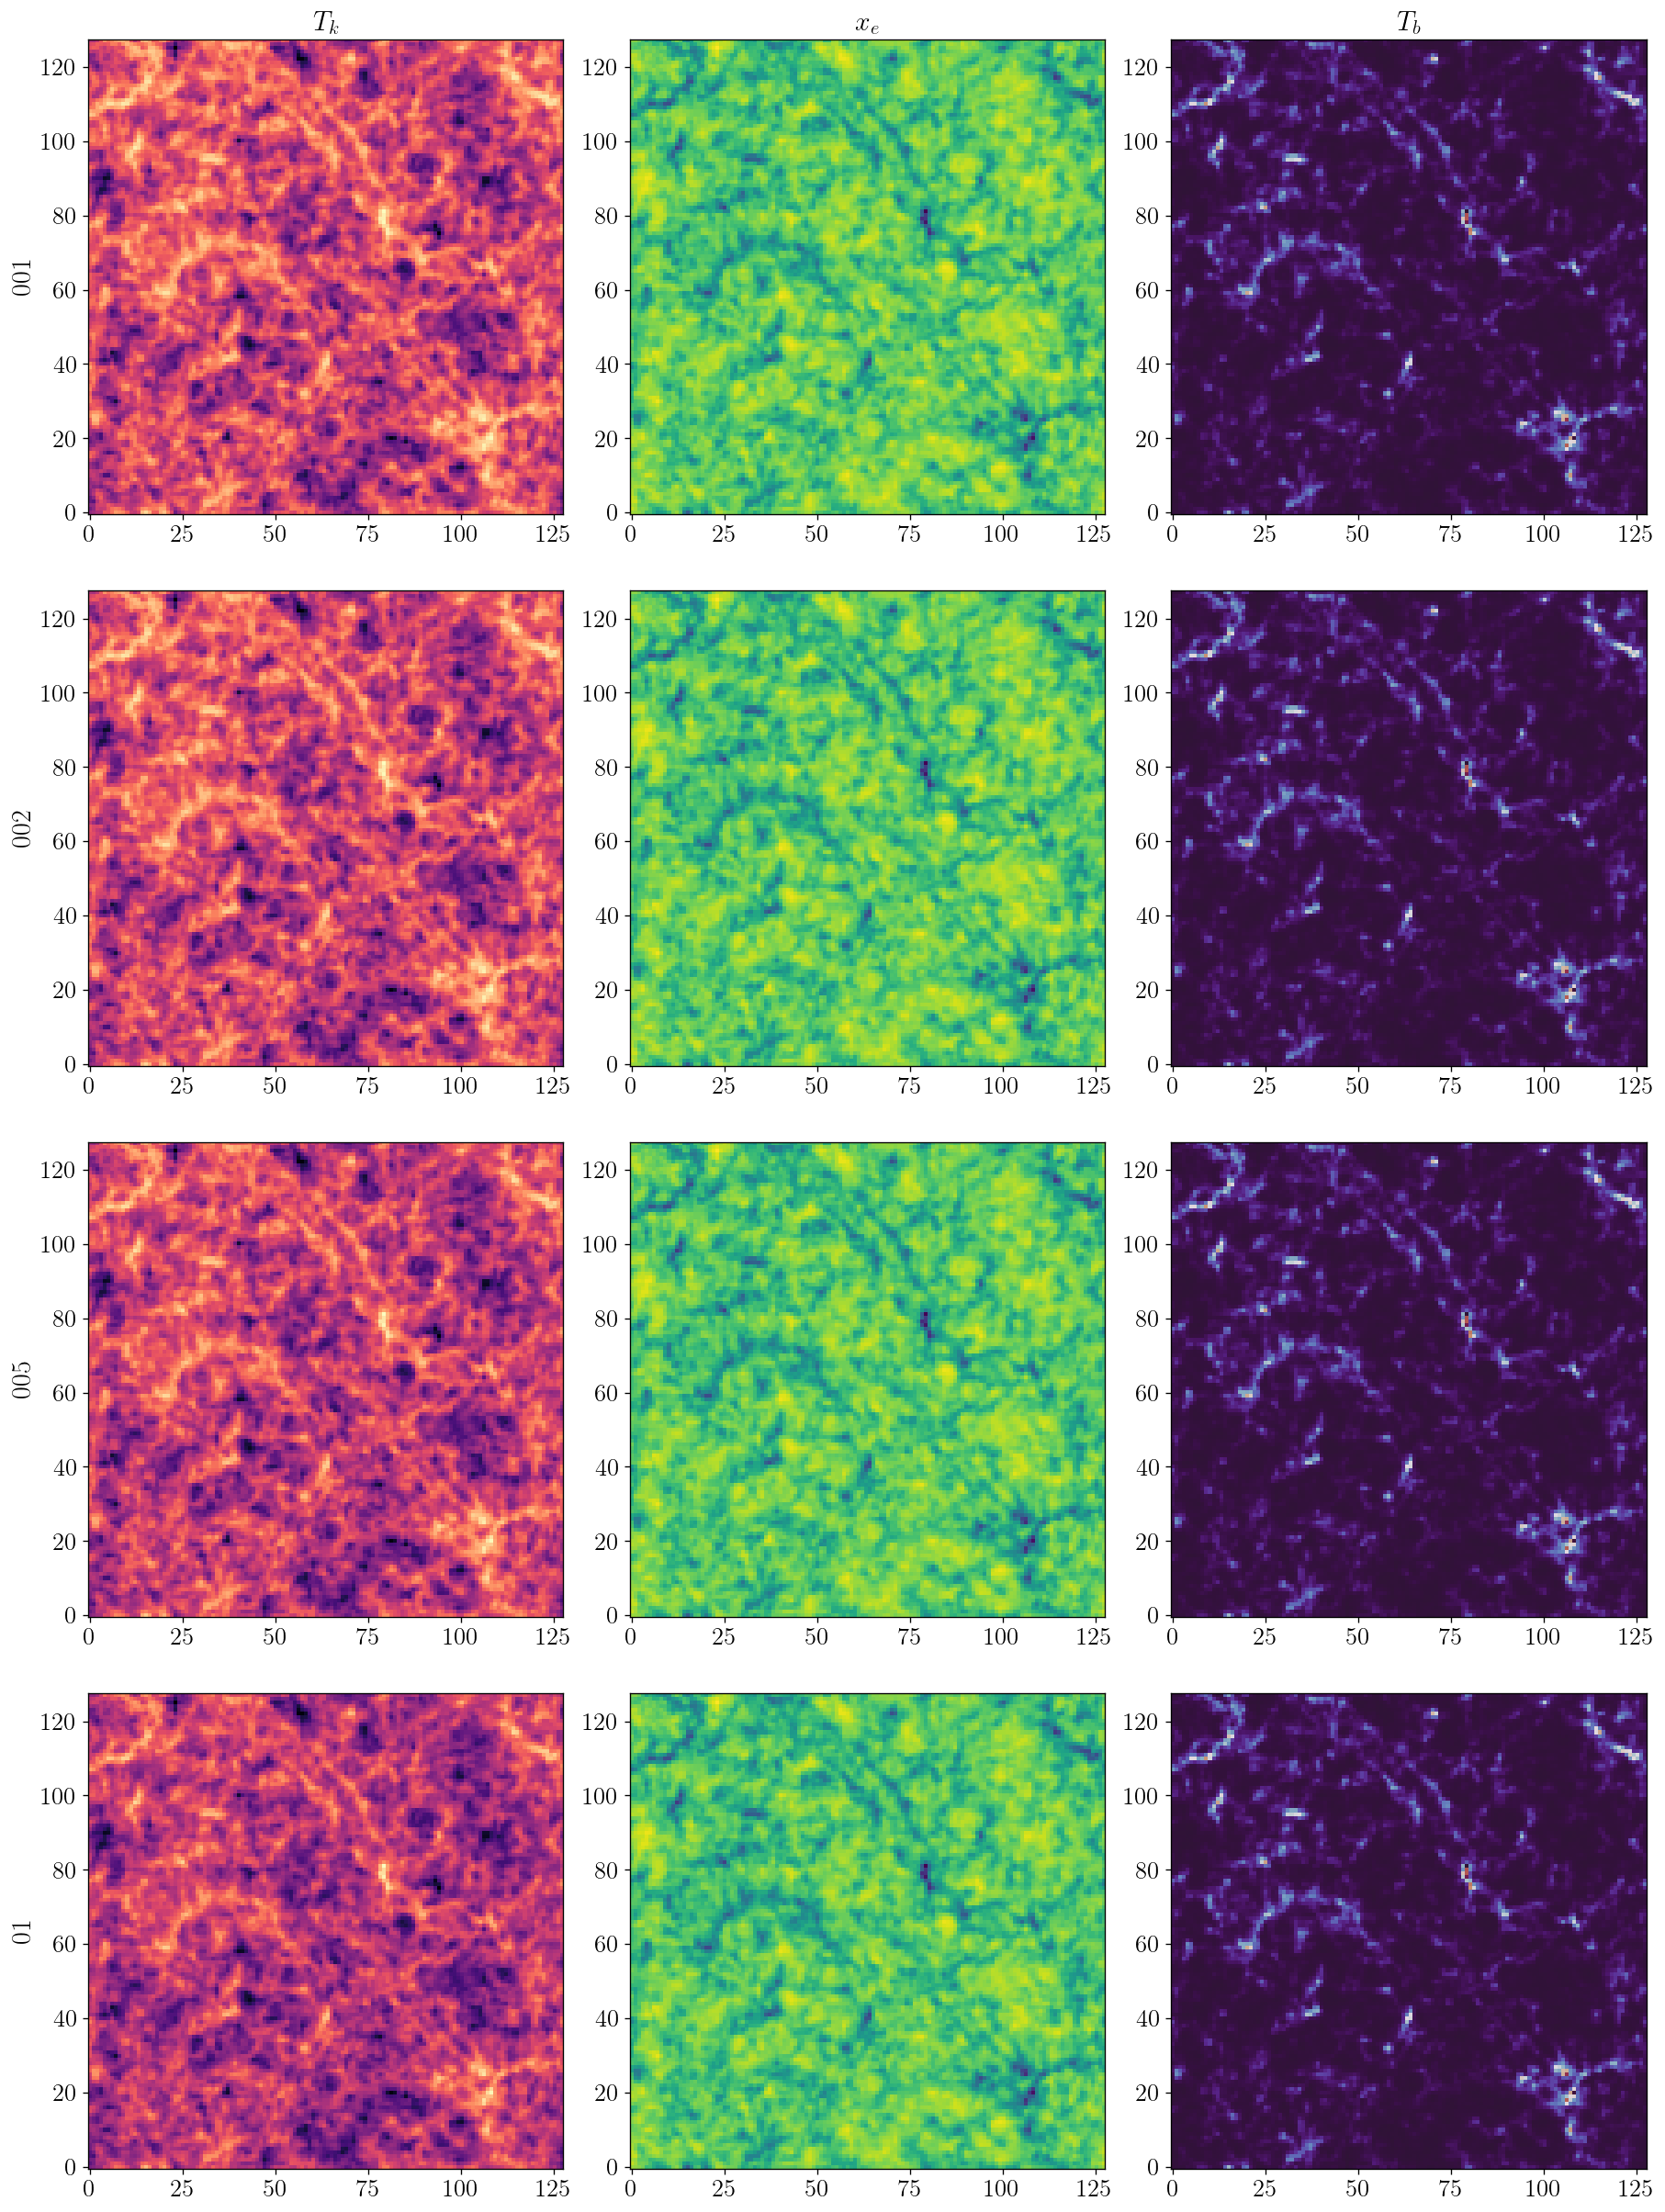

In [6]:
cmap_dict = {
    'T_k' : cms['magma'],
    'x_e' : cms['viridis'],
    'T_b' : cms['twilight_shifted']
}
title_dict = {
    'T_k' : r'Kinetic temperature $T_k$ [K]',
    'x_e' : r'Ionization fraction $x_e$',
    'T_b' : r'Brightness temperature $T_b$ [mK]'
}
zf_labels = [
    r'$z+\Delta z/z=1.001$',
    r'$z+\Delta z/z=1.002$',
    r'$z+\Delta z/z=1.005$',
    r'$z+\Delta z/z=1.01$',
]

fig, axs = plt.subplots(4, 3, figsize=(15, 20), layout='constrained')

for i in range(4):
    for j, k in enumerate(keys):
        ax = axs[i, j]
        ax.imshow(box_s[k][i][:, :, 1], origin='lower', cmap=cmap_dict[k])

for j, k in enumerate(keys):
    axs[0, j].set_title(f'${k}$')
for i in range(4):
    axs[i, 0].set_ylabel(zf_s[i])

fig.savefig('xesink.png', dpi=120)

## Power spectrum

In [7]:
import py21cmfast as p21c

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [8]:
def compute_power(
   box,
   length,
   n_psbins,
   log_bins=True,
   ignore_kperp_zero=True,
   ignore_kpar_zero=False,
   ignore_k_zero=False,
):
    # Determine the weighting function required from ignoring k's.
    k_weights = np.ones(box.shape, int)
    n0 = k_weights.shape[0]
    n1 = k_weights.shape[-1]

    if ignore_kperp_zero:
        k_weights[n0 // 2, n0 // 2, :] = 0
    if ignore_kpar_zero:
        k_weights[:, :, n1 // 2] = 0
    if ignore_k_zero:
        k_weights[n0 // 2, n0 // 2, n1 // 2] = 0

    res = pbox.tools.get_power(
        box,
        boxlength=length,
        bins=n_psbins,
        bin_ave=False,
        get_variance=False,
        log_bins=log_bins,
        k_weights=k_weights,
    )

    res = list(res)
    k = res[1]
    if log_bins:
        k = np.exp((np.log(k[1:]) + np.log(k[:-1])) / 2)
    else:
        k = (k[1:] + k[:-1]) / 2

    res[1] = k
    return res

BOX_LEN = 256 # [Mpc]

def powerspectra(brightness_temp, n_psbins=50, nchunks=20, min_k=0.1, max_k=1.0, logk=True):
    data = []
    chunk_indices = list(range(0,brightness_temp.n_slices,round(brightness_temp.n_slices / nchunks),))    
    
    if len(chunk_indices) > nchunks:
        chunk_indices = chunk_indices[:-1]
    chunk_indices.append(brightness_temp.n_slices)

    for i in range(nchunks):
        start = chunk_indices[i]
        end = chunk_indices[i + 1]
        chunklen = (end - start) * brightness_temp.cell_size

        power, k = compute_power(
            brightness_temp.brightness_temp[:, :, start:end],
            (BOX_LEN, BOX_LEN, chunklen),
            n_psbins,
            log_bins=logk,
        )
        data.append({"k": k, "delta": power * k ** 3 / (2 * np.pi ** 2)})
    return data

In [9]:
lc_s = [p21c.LightCone.read(f"{ddir}/lc_fc_xdecay_zf{zf_s[i]}_sf{sf_s[i]}_xesink.h5") for i in range(4)]
ps_s = [powerspectra(lc) for lc in lc_s]

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/powerbox/tools.py:325: UserWarning: One or more radial bins had no cells within it.
  return angular_average(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/powerbox/tools.py:180: RuntimeWarning: invalid value encountered in divide
  np.bincount(


In [11]:
vmin = np.max(box_s['T_b'])
vmax = np.max(box_s['T_b'])

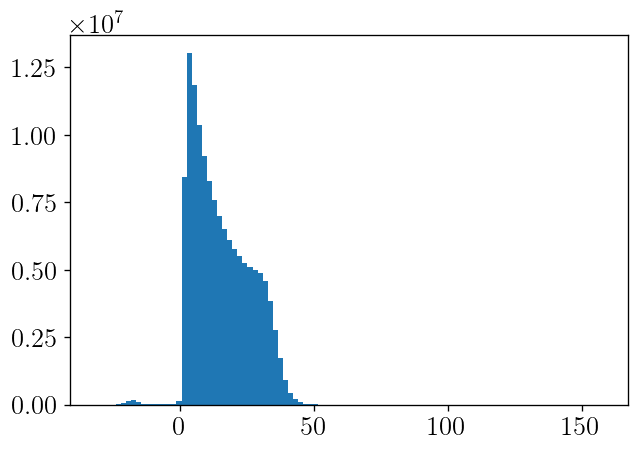

In [10]:
plt.hist(np.array(box_s['T_b']).flatten(), bins=100);

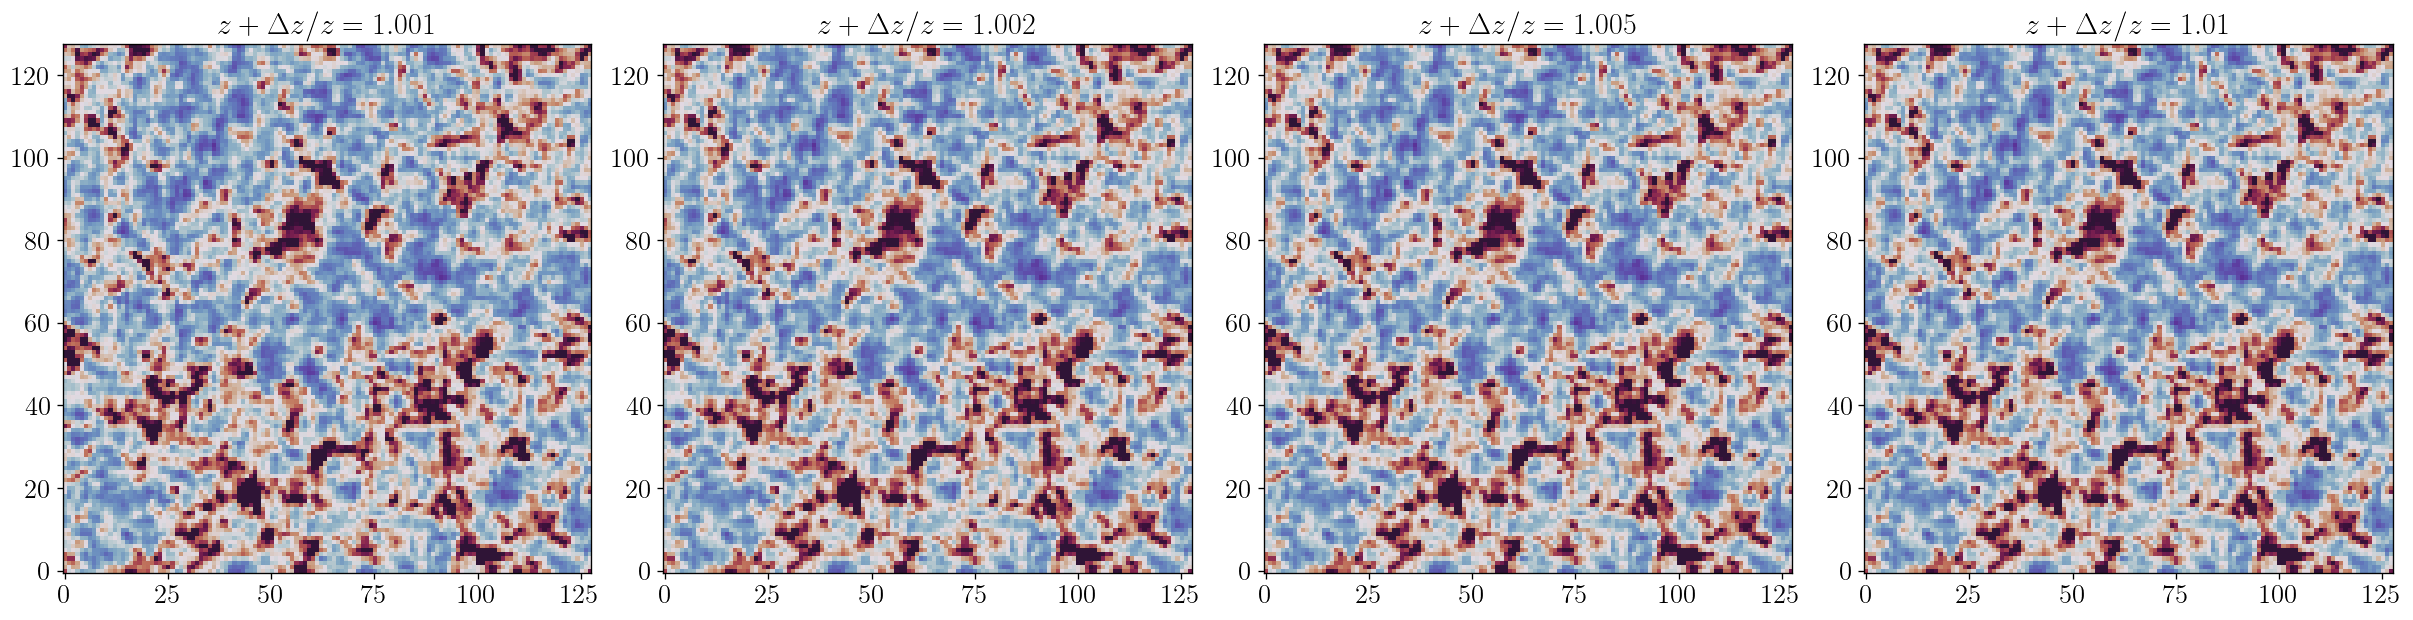

In [12]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), layout='constrained')
for i in range(4):
    ax = axs[i]
    z = box_s['T_b'][i][:, :, 1000]
    ax.imshow(z/np.mean(z), origin='lower', cmap=cmap_dict['T_b'], vmin=0, vmax=2)
    ax.set_title(zf_labels[i])

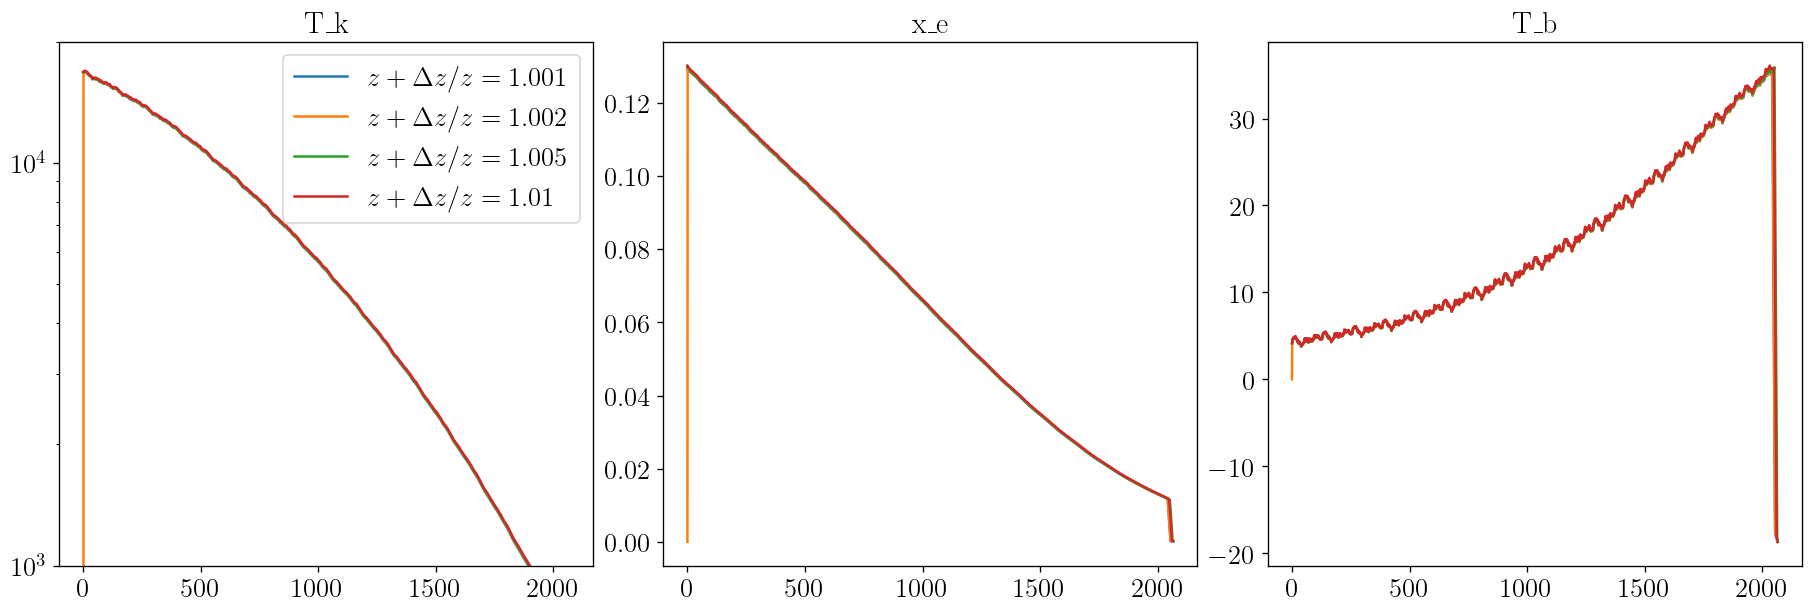

In [84]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), layout='constrained')

for i in range(4):
    ax = axs[0]
    ax.plot(np.mean(box_s['T_k'][i], axis=(0,1)), label=zf_labels[i])
    ax.set(title='T_k')
    ax = axs[1]
    ax.plot(np.mean(box_s['x_e'][i], axis=(0,1)))
    ax.set(title='x_e')
    ax = axs[2]
    ax.plot(np.mean(box_s['T_b'][i], axis=(0,1)))
    ax.set(title='T_b')
axs[0].set(yscale='log')
axs[0].set(ylim=(1e3, 2e4))
axs[0].legend()
#axs[1].set(yscale='log')
#axs[1].set(ylim=(1e3, 2e4))

[Text(0.5, 0, '$k$ [Mpc$^{-1}$]'),
 Text(0.5, 1.0, '$\\Delta_{21}^2(k)$ difference to zf001 [mK$^2$]')]

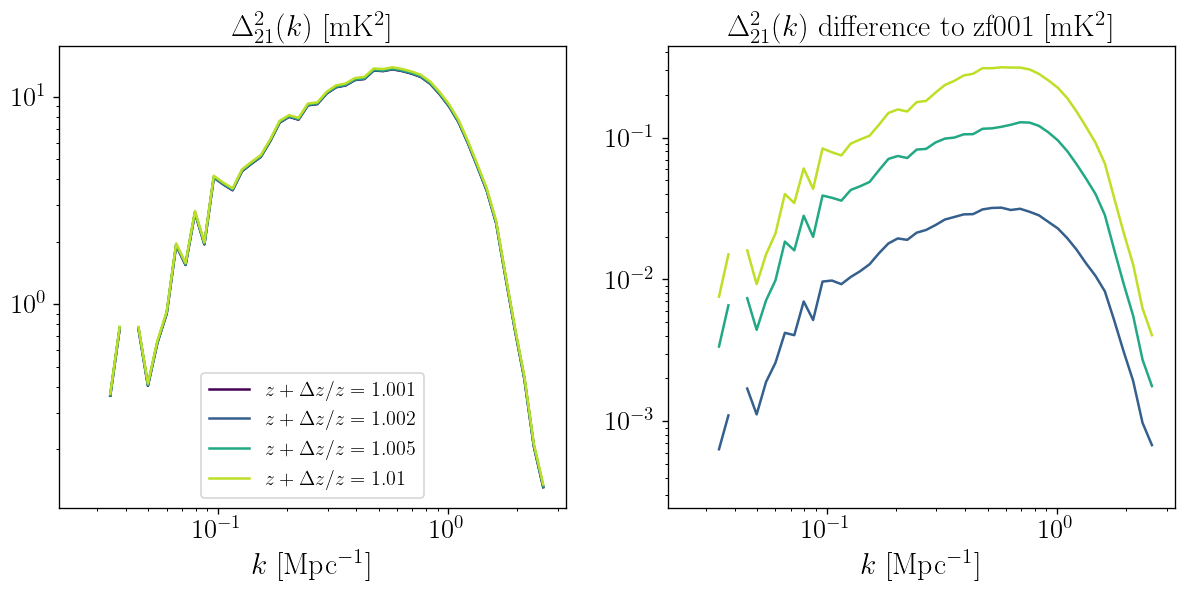

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

x_s = [0., 0.3, 0.6, 0.9]
color_s = [cms['viridis'](x) for x in x_s]

delta_base = ps_s[0][10]['delta']

for i in range(4):
    ps = ps_s[i]
    ax = axs[0]
    ax.plot(ps[10]['k'], ps[10]['delta'], color=color_s[i], label=zf_labels[i])
    ax = axs[1]
    ax.plot(ps[10]['k'], ps[10]['delta']-delta_base, color=color_s[i], label=zf_labels[i])

axs[0].set(xscale='log', yscale='log')
axs[1].set(xscale='log', yscale='log')
axs[0].legend(fontsize=12)

axs[0].set(xlabel=r'$k$ [Mpc$^{-1}$]', title=r'$\Delta_{21}^2(k)$ [mK$^2$]')
axs[1].set(xlabel=r'$k$ [Mpc$^{-1}$]', title=r'$\Delta_{21}^2(k)$ difference to zf001 [mK$^2$]');

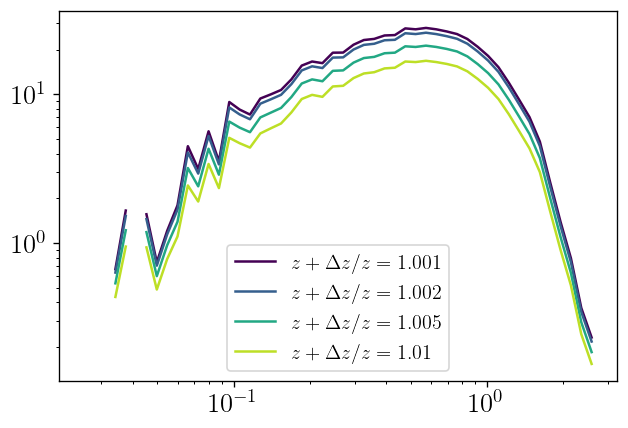

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

x_s = [0., 0.3, 0.6, 0.9]
color_s = [cms['viridis'](x) for x in x_s]

for i in range(4):
    ps = ps_s[i]
    ax.plot(ps[10]['k'], ps[10]['delta'], color=color_s[i], label=zf_labels[i])

ax.set(xscale='log', yscale='log')
ax.legend(fontsize=12)